In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


print("Running on", device)

Running on cpu


## Data loader

In [2]:
class TacoDataset(torch.utils.data.Dataset):
    def __init__(self, datatype = "train", img_size = None):
        self.datatype = datatype
        self.root = '/mnt/c/Users/frede/Downloads/data_wastedetection/'
        self.anns_file_path = self.root + '/' + 'annotations.json'
        self.coco = COCO(self.anns_file_path)
        self.ids = list(sorted(self.coco.imgs.keys()))
        

        self.img_size = img_size


        trns = []      
        self.transforms = transforms.Compose([
            # transforms.PILToTensor(),
            *trns,
            transforms.ToTensor(),
        ])
        
        self.category_id_to_name = {d["id"]: d["name"] for d in self.coco.dataset["categories"]}
        
        # split into train and test
        np.random.seed(0)
        idxs = np.arange(len(self.ids))
        idxs = np.random.permutation(idxs)
        self.train_idxs = idxs[:int(0.8*len(idxs))]
        self.test_idxs = idxs[int(0.8*len(idxs)):]
        self.train_idxs = self.train_idxs[:int(0.8*len(self.train_idxs))]
        self.val_idxs = self.train_idxs[int(0.8*len(self.train_idxs)):]

        print(f"Number of train images: {len(self.train_idxs)}")
        print(f"Number of val images: {len(self.val_idxs)}")
        print(f"Number of test images: {len(self.test_idxs)}")
        
    def __getitem__(self, idx):
        if self.datatype == "train":
            idx = self.train_idxs[idx]
        elif self.datatype == "val":
            idx = self.val_idxs[idx]
        elif self.datatype == "test":
            idx = self.test_idxs[idx]
            
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[idx]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        

        
        # Resize image and calculate the scaling factor based on the aspect ratio
        if self.img_size is not None:
            img_width, img_height = img.size
            aspect_ratio = img_width / img_height 
            target_width = int(self.img_size[0]) 
            target_height = int(self.img_size[0] / aspect_ratio) if self.img_size is not None else img_height
            if target_height > self.img_size[1]:
                target_height = int(self.img_size[1])
                target_width = int(self.img_size[1] * aspect_ratio)

            img = img.resize((target_width, target_height), resample=Image.LANCZOS) # Image.ANTIALIAS)

        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            if self.img_size is None:
                xmin = coco_annotation[i]['bbox'][0]
                ymin = coco_annotation[i]['bbox'][1]
                xmax = xmin + coco_annotation[i]['bbox'][2]
                ymax = ymin + coco_annotation[i]['bbox'][3]
                boxes.append([xmin, ymin, xmax, ymax])
            else:
                xmin = coco_annotation[i]['bbox'][0] * target_width / img_width
                ymin = coco_annotation[i]['bbox'][1] * target_height / img_height
                xmax = (coco_annotation[i]['bbox'][0] + coco_annotation[i]['bbox'][2]) * target_width / img_width
                ymax = (coco_annotation[i]['bbox'][1] + coco_annotation[i]['bbox'][3]) * target_height / img_height
                boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Labels (In my case, I only one class: target class or background)
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        label_ids, labels = [], []
        for i in range(num_objs):
            labels.append(coco_annotation[i]['category_id'])
            # label_ids.append(coco_annotation[i]['category_id'])
            # labels.append(self.category_id_to_name[coco_annotation[i]['category_id']])
        labels = torch.as_tensor(labels)
        # label_ids = torch.as_tensor(label_ids, dtype=torch.int64)
        
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        # my_annotation["label_ids"] = label_ids
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        # return len(self.ids)
        if self.datatype == "train":
            return len(self.train_idxs)
        elif self.datatype == "val":
            return len(self.val_idxs)
        elif self.datatype == "test":
            return len(self.test_idxs)

def get_dataloader(dataset):
    # collate_fn needs for batch
    def collate_fn(batch):
        return tuple(zip(*batch))

    # Batch size
    train_batch_size = 1

    # own DataLoader
    data_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=train_batch_size,
                                            shuffle=True,
                                            num_workers=4,
                                            collate_fn=collate_fn)

    return data_loader

def show_img(img, annotations, label_dict, ax = None):
    """Show image with annotations"""
    if ax is None:
        fig, ax = plt.subplots()
    
    img = img.cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_axis_off()
    
    for idx in range(len(annotations["boxes"])):
        box = annotations["boxes"][idx].cpu()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # add label
        label_id = annotations["labels"][idx].cpu()
        label = label_dict[label_id.item()]
        ax.text(xmin, ymin, f"{label}", fontsize=12, color="r")
        
        
    # plt.show()


loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Number of train images: 960
Number of val images: 192
Number of test images: 300
[{'boxes': tensor([[2.2357e+02, 6.7339e+01, 2.8433e+02, 2.1856e+02],
        [8.4773e+01, 7.6269e+01, 1.3192e+02, 2.1109e+02],
        [3.0893e+01, 1.4639e-01, 9.1947e+01, 2.0758e+02],
        [1.7687e+02, 8.9444e+01, 2.3089e+02, 2.1856e+02],
        [1.2635e+02, 8.9005e+01, 1.7804e+02, 2.1490e+02],
        [2.4553e+02, 6.7339e+01, 2.7643e+02, 8.1685e+01],
        [1.9400e+02, 9.7056e+01, 2.1669e+02, 1.1389e+02],
        [1.4187e+02, 9.3103e+01, 1.6325e+02, 1.1126e+02],
        [8.9312e+01, 7.6269e+01, 1.1640e+02, 9.0468e+01],
        [3.1040e+01, 1.4639e-01, 5.5783e+01, 1.5224e+01]]), 'labels': tensor([ 4,  5,  6, 16, 16,  7,  7,  7,  7,  8]), 'image_id': tensor([12]), 'area': tensor([329938.0000, 227212.5000, 324005.0000, 285954.0000, 269118.0000,
         17325.5000,  14550.5000,  14852.5000,  14988.0000,  14926.5000])}]


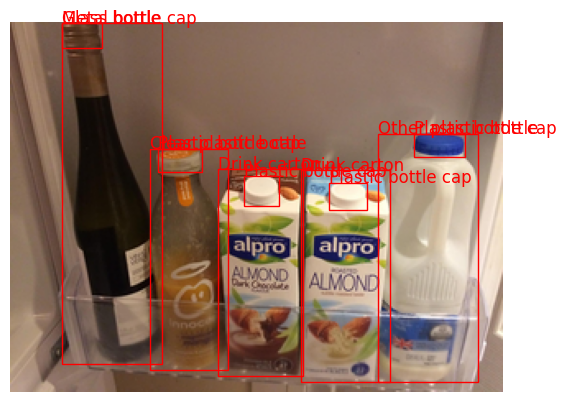

In [3]:
# create own Dataset
dataset = TacoDataset(img_size=(300, 300), datatype="train")
data_loader = get_dataloader(dataset)


# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    
    show_img(imgs[0], annotations[0], dataset.category_id_to_name)
    plt.savefig("test.png")
    
    break

## Selective search

In [5]:
import cv2


# Load image
img, annotations = dataset[0]

# Convert to cv2
img_array = img.cpu().numpy()#.transpose(1, 2, 0)
# img_cv2 = cv2.imdecode(img.cpu().numpy().transpose(1, 2, 0), cv2.IMREAD_COLOR)
img_cv2 = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)


# Selective search
SS = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

SS.setBaseImage(img_cv2)
SS.switchToSelectiveSearchFast()
results = SS.process()

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 225


In [10]:
img_array.shape

(4160, 3120, 3)

In [6]:
annotations

{'boxes': tensor([[1467.1702, 1496.3195, 2162.1702, 2492.6528]]),
 'labels': tensor([50]),
 'image_id': tensor([471]),
 'area': tensor([368758.4375])}